In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install scikit-misc

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.8 MB/s eta 0:00:0000:010:01


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import re

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.scDEED as scd
import BacSC.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
import gzip
import shutil
data_dir = "../../data/BacDrop/raw_data/"
file_names = ["GSM5456487_MGH66_Abx3_P2_align2._CDS.tsv", "GSM5456488_MGH66_Abx3_P3_align2._CDS.tsv", "GSM5456489_MGH66_Abx3_P4_align2._CDS.tsv",
              "GSM6081206_Abx2_S2_P2_CDS.tsv", "GSM6081207_Abx2_S2_P3_CDS.tsv", "GSM6081208_Abx2_S2_P4_CDS.tsv"]

for f in file_names:
    file_name_full = data_dir + f

    if not f in os.listdir(data_dir):
        if f + ".gz" in os.listdir(data_dir):
            print("unzipping data...")
            with gzip.open(file_name_full + ".gz","rb") as f_in, open(file_name_full,"wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            raise FileNotFoundError(f"{f} does not exist in regular or zipped form")

In [5]:
adatas = []
for f in file_names:
    file_name_full = data_dir + f
    print(f)
    adata = sc.read_csv(file_name_full, delimiter="\t", first_column_names=True)
    adata = adata.transpose()
    adata.var_names_make_unique()
    adata.X = sps.csr_matrix(adata.X)
    adatas.append(adata)
    
adatas

GSM5456487_MGH66_Abx3_P2_align2._CDS.tsv
GSM5456488_MGH66_Abx3_P3_align2._CDS.tsv
GSM5456489_MGH66_Abx3_P4_align2._CDS.tsv
GSM6081206_Abx2_S2_P2_CDS.tsv
GSM6081207_Abx2_S2_P3_CDS.tsv
GSM6081208_Abx2_S2_P4_CDS.tsv


[AnnData object with n_obs × n_vars = 392941 × 3987,
 AnnData object with n_obs × n_vars = 390322 × 3391,
 AnnData object with n_obs × n_vars = 326515 × 3439,
 AnnData object with n_obs × n_vars = 43676 × 3787,
 AnnData object with n_obs × n_vars = 44299 × 3229,
 AnnData object with n_obs × n_vars = 36731 × 3330]

In [6]:
adatas[0].obs["treatment"] = "meropenem"
adatas[1].obs["treatment"] = "ciprofloxacin"
adatas[2].obs["treatment"] = "gentamicin"
adatas[3].obs["treatment"] = "meropenem"
adatas[4].obs["treatment"] = "ciprofloxacin"
adatas[5].obs["treatment"] = "gentamicin"


adatas[0].obs["replicate"] = 1
adatas[1].obs["replicate"] = 1
adatas[2].obs["replicate"] = 1
adatas[3].obs["replicate"] = 2
adatas[4].obs["replicate"] = 2
adatas[5].obs["replicate"] = 2

In [7]:
data_untr = ad.concat(adatas, join="outer", fill_value=0)
data_untr

AnnData object with n_obs × n_vars = 1234484 × 4514
    obs: 'treatment', 'replicate'

In [8]:
print(f"Zero inflation of data: {((np.prod(data_untr.X.shape) - data_untr.X.getnnz()) / np.prod(data_untr.X.shape)).round(3)}")


Zero inflation of data: 0.999


### Filter cells

--> filter based on mean absolute standard deviation

In [9]:
importlib.reload(ut)
data_gene = data_untr.copy()
# sc.pp.filter_cells(data_gene, min_genes=15)
# sc.pp.filter_genes(data_gene, min_cells=2)
# sc.pp.calculate_qc_metrics(data_gene, var_type="genes", percent_top=None, log1p=True, inplace=True)

data_gene = ut.filter_outliers(data_untr, nmads=15, min_cells=2, min_genes=15)
# print(data_untr.obs.outlier.value_counts())
print(f"Total number of cells: {data_untr.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

Total number of cells: 1234484
Number of cells after filtering: 19638


AnnData object with n_obs × n_vars = 19638 × 3659
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

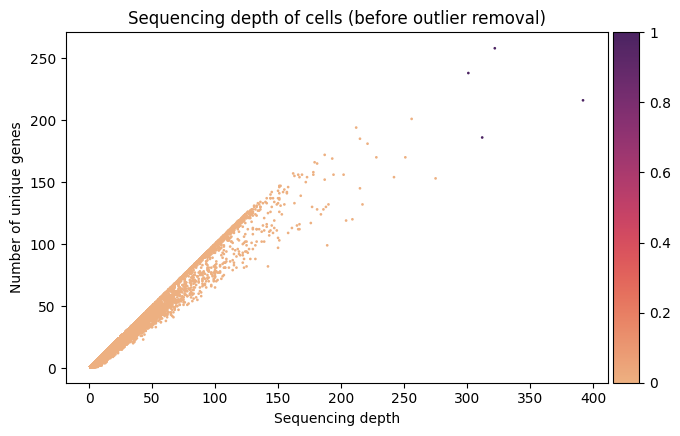

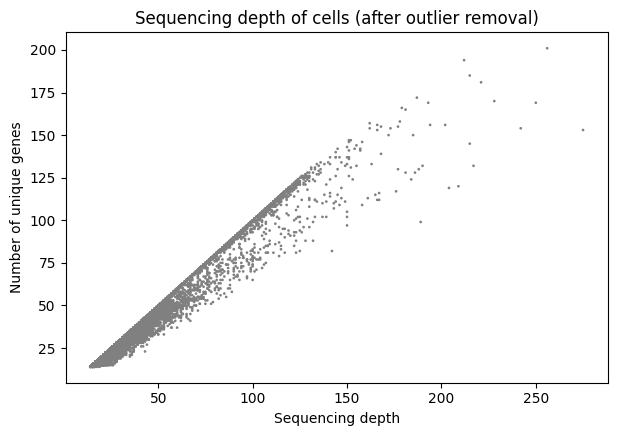

In [10]:
g = sc.pl.scatter(data_untr, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [11]:
data_gene.layers["counts"] = data_gene.X.copy()

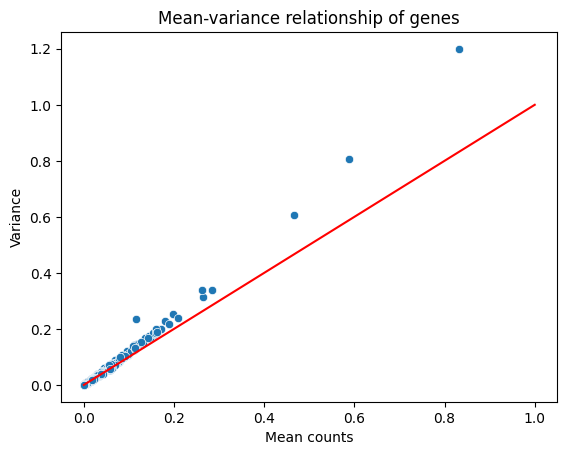

In [12]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [13]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [14]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [15]:
data_gene.var

n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-AF52_RS00165                   13     0.000662           0.000662   
cds-AF52_RS00180                    2     0.000102           0.000102   
cds-AF52_RS00275                    6     0.000306           0.000305   
cds-AF52_RS00620                   14     0.000713           0.000713   
cds-AF52_RS01000                  348     0.017772           0.017616   
...                               ...          ...                ...   
cds-WP_187079193.1                 31     0.001579           0.001577   
cds-WP_187079194.1                 39     0.002037           0.002035   
cds-WP_187079195.1                  4     0.000204           0.000204   
cds-WP_187079196.1                 21     0.001171           0.001171   
cds-WP_187079197.1                 11     0.000560           0.000560   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
cds-AF52_RS00165                99.933802          13.0            2.639057   
cds-AF52_RS00180                99.989816           2.0            1.098612   
cds-AF52_RS00275                99.969447           6.0            1.945910   
cds-AF52_RS00620                99.928710          14.0            2.708050   
cds-AF52_RS01000                98.227925         349.0            5.857933   
...                                   ...           ...                 ...   
cds-WP_187079193.1              99.842143          31.0            3.465736   
cds-WP_187079194.1              99.801405          40.0            3.713572   
cds-WP_187079195.1              99.979631           4.0            1.609438   
cds-WP_187079196.1              99.893064          23.0            3.178054   
cds-WP_187079197.1              99.943986          11.0            2.484907   

                    n_cells  var_counts  is_scd_outlier  nb_overdisp  \
cds-AF52_RS00165         13    0.000661           False     0.015929   
cds-AF52_RS00180          2    0.000102           False     0.000202   
cds-AF52_RS00275          6    0.000305           False     0.014603   
cds-AF52_RS00620         14    0.000713           False     0.026059   
cds-AF52_RS01000        348    0.017557           False     0.482005   
...                     ...         ...             ...          ...   
cds-WP_187079193.1       31    0.001576           False     0.029417   
cds-WP_187079194.1       39    0.002134           False     0.028569   
cds-WP_187079195.1        4    0.000204           False     0.010316   
cds-WP_187079196.1       21    0.001374           False     0.019140   
cds-WP_187079197.1       11    0.000560           False     0.016529   

                    nb_overdisp_cutoff    nb_mean    nb_umi  \
cds-AF52_RS00165              0.015929  -8.569083  0.851245   
cds-AF52_RS00180              0.010000  -8.548560 -0.687911   
cds-AF52_RS00275              0.014603  -9.103086  0.663265   
cds-AF52_RS00620              0.026059  -8.233974  0.647022   
cds-AF52_RS01000              0.482005 -11.381457  4.555119   
...                                ...        ...       ...   
cds-WP_187079193.1            0.029417  -8.007223  1.087043   
cds-WP_187079194.1            0.028569  -7.694961  1.038026   
cds-WP_187079195.1            0.010316  -8.359074 -0.170551   
cds-WP_187079196.1            0.019140  -8.084513  0.905785   
cds-WP_187079197.1            0.016529  -8.914730  0.964991   

                    Intercept_step1_sct  log_umi_step1_sct  \
cds-AF52_RS00165             -10.689452           2.305287   
cds-AF52_RS00180               0.633734          -7.529174   
cds-AF52_RS00275              -4.054589          -3.006792   
cds-AF52_RS00620                    NaN                NaN   
cds-AF52_RS01000             -13.859414           6.025816   
...                                 ...                ...   
cds-WP_187079193.1                  NaN                NaN   
cds-WP_187079194.1            -6.637846           0.315258   
cds-WP_1870791

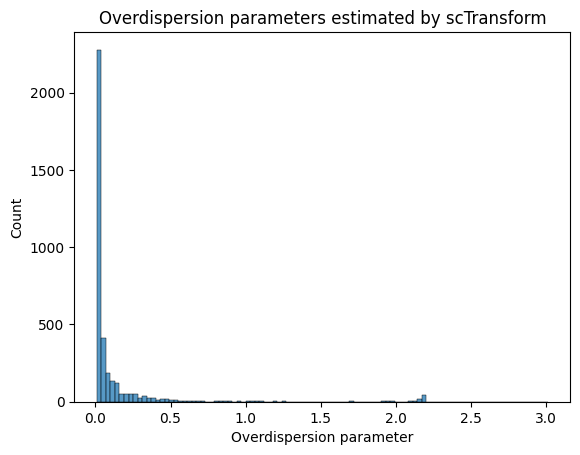

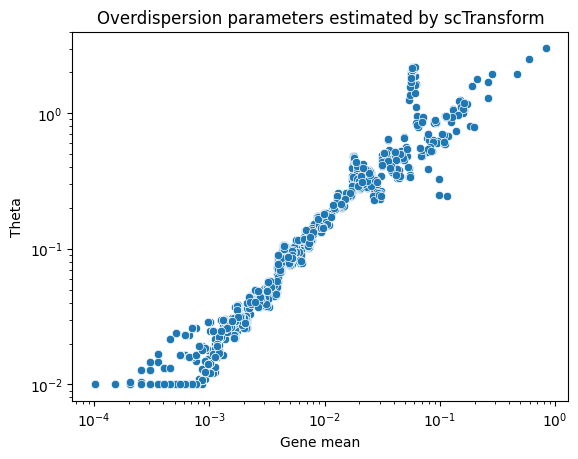

In [16]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [17]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [18]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.pp.highly_variable_genes(data_gene, n_top_genes=2500, flavor="seurat_v3", layer="counts")
data_gene = data_gene[:, data_gene.var.highly_variable]
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

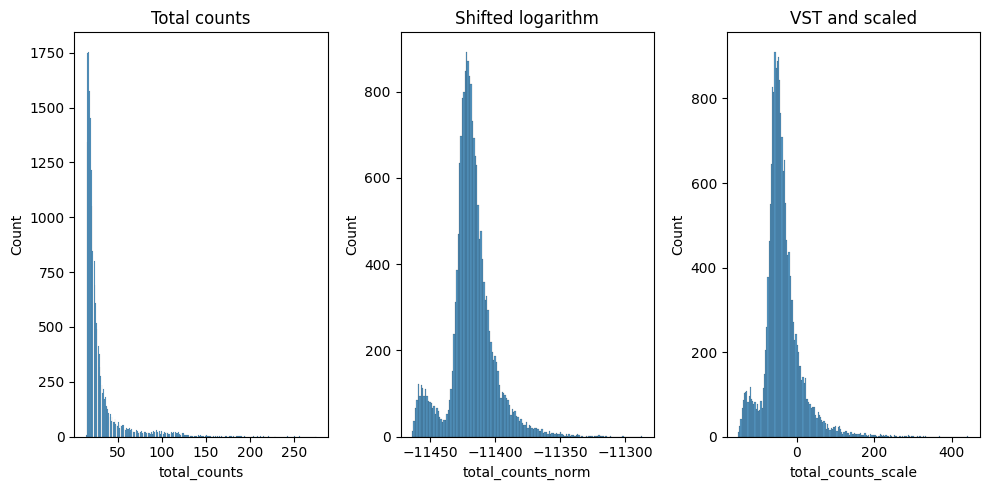

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [20]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 19477 × 2078
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'counts'


In [21]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

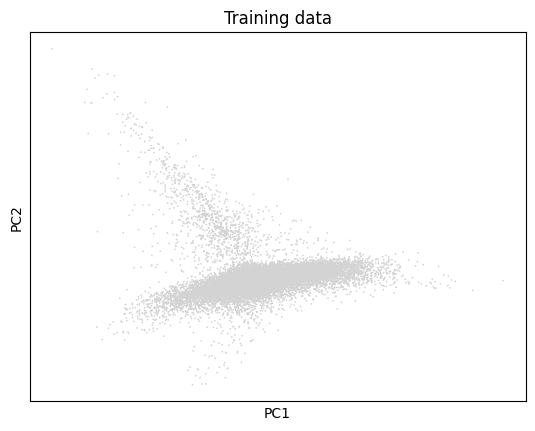

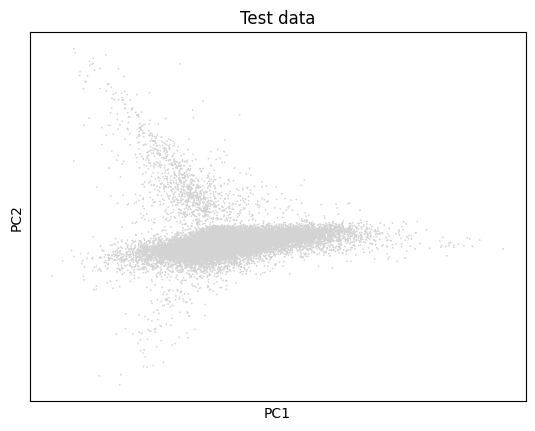

In [22]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [23]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:5


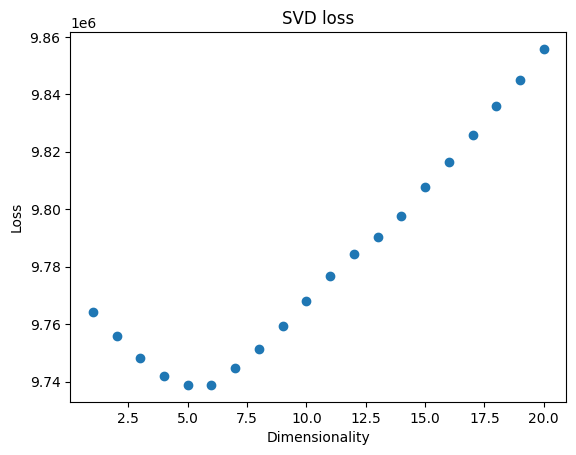

In [24]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

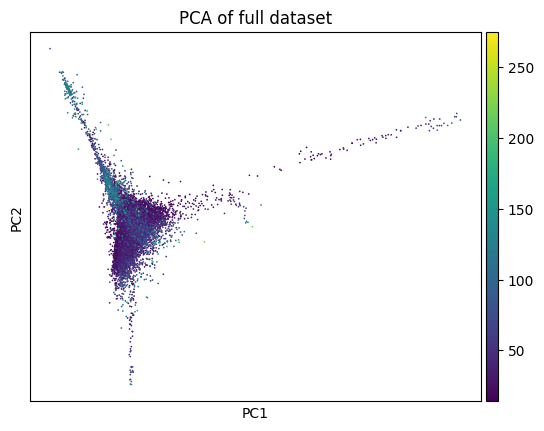

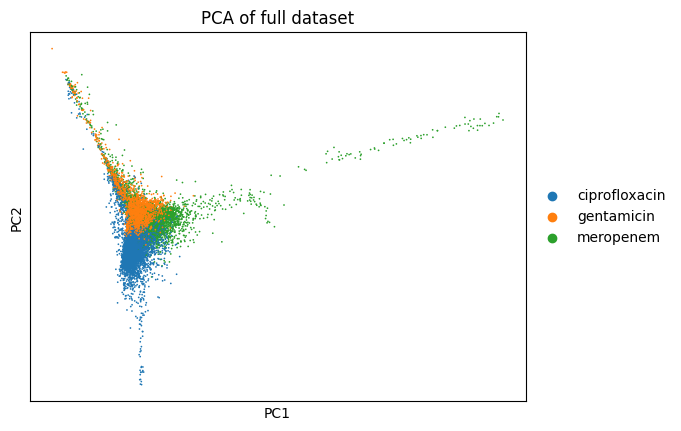

In [25]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

sc.pl.pca(data_gene, color="treatment", cmap="viridis", title="PCA of full dataset")
plt.show()

In [26]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [27]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

565


In [28]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="Klebs_antibiotics_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 150
Optimal min_dist: 0.1


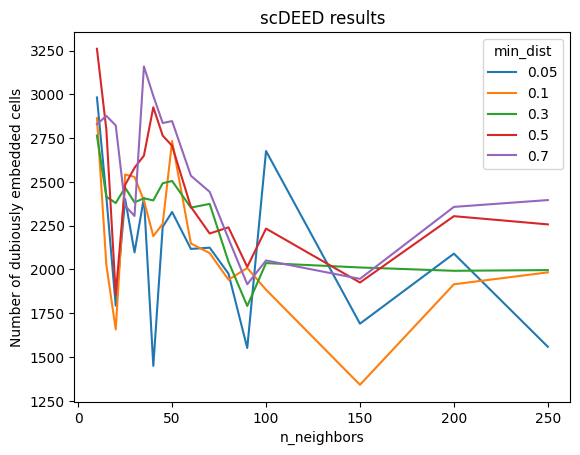

In [29]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [30]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


# k_opt = 4
# n_neighbors_opt = 30
# min_dist_opt = 0.3
print(k_opt)

5


In [31]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [32]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


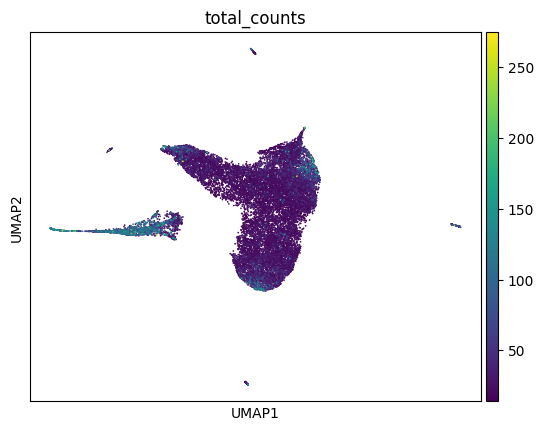

In [33]:
# sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
# plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

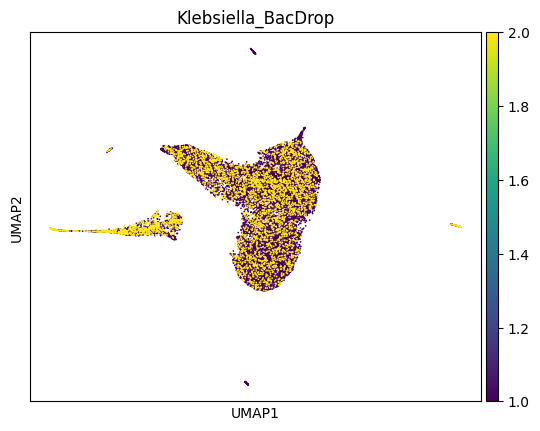

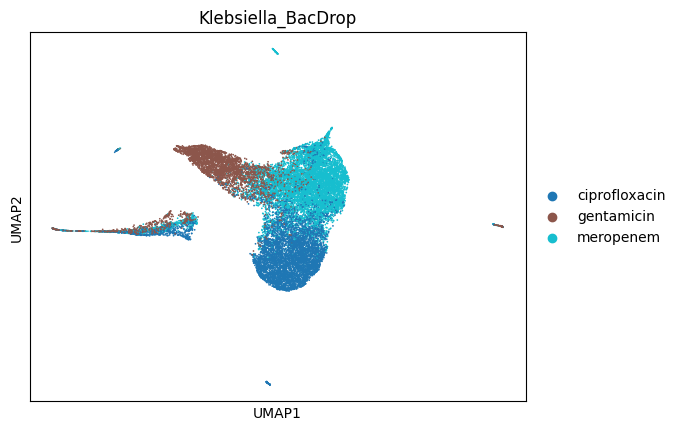

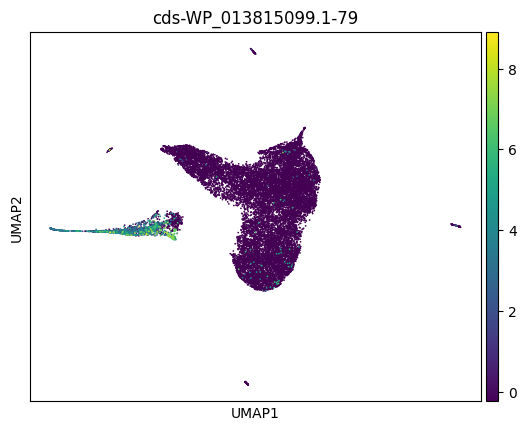

In [34]:
sc.pl.umap(data_gene, color="replicate", palette="tab10", title="Klebsiella_BacDrop")
plt.show()

sc.pl.umap(data_gene, color="treatment", palette="tab10", title="Klebsiella_BacDrop")
plt.show()

tag = "cds-WP_013815099.1-79"
sc.pl.umap(data_gene, color=tag)
plt.show()

In [35]:
data_path = "../../data/BacDrop"

data_gene.write(data_path + "/antibiotics_data_processed_3.h5ad")


## Clustering

### Train/test-split for clustering

In [37]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

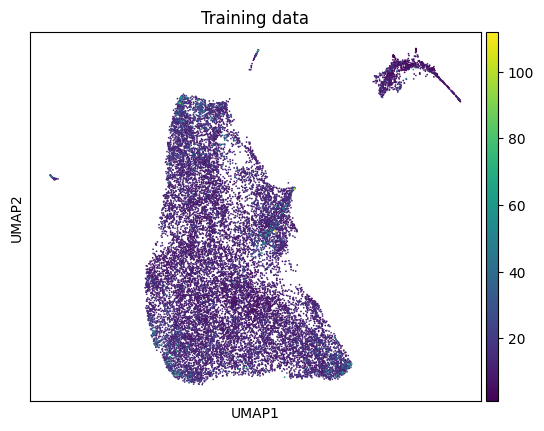

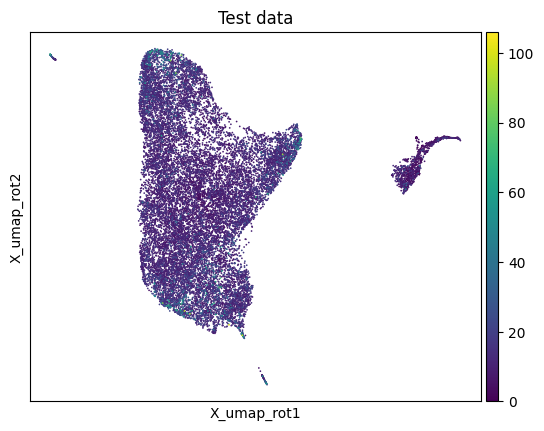

In [38]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [39]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)

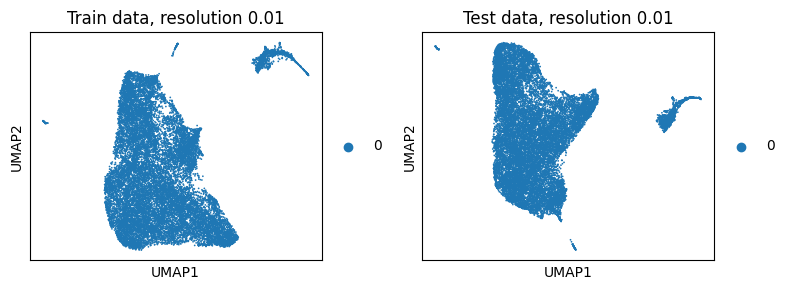

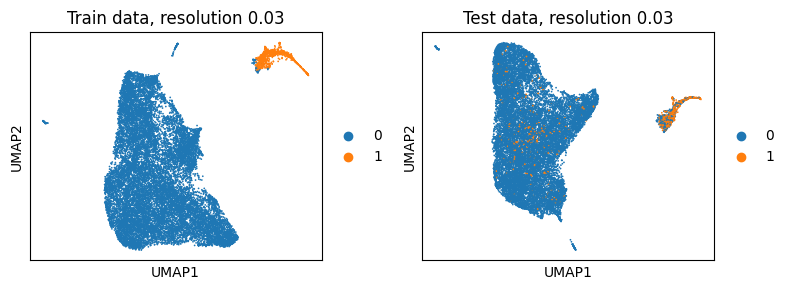

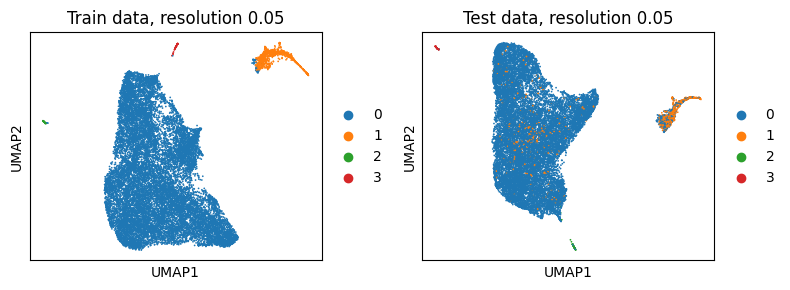

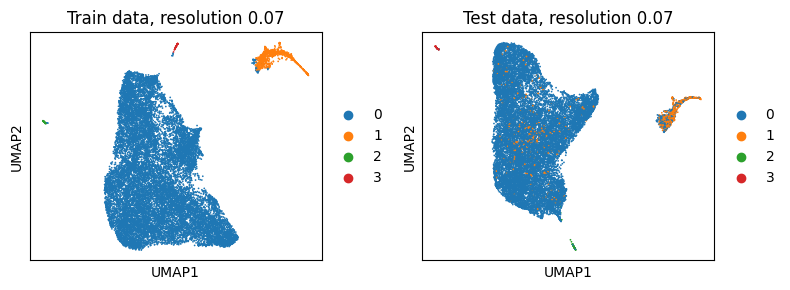

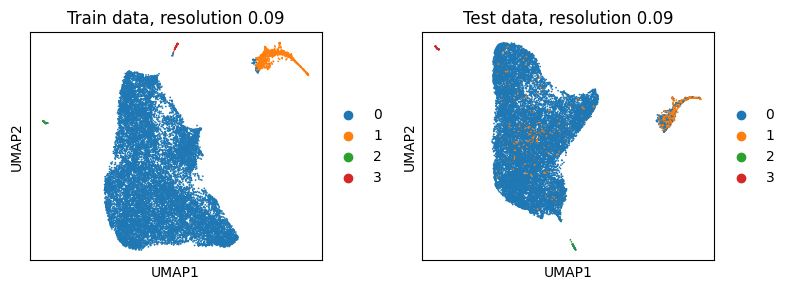

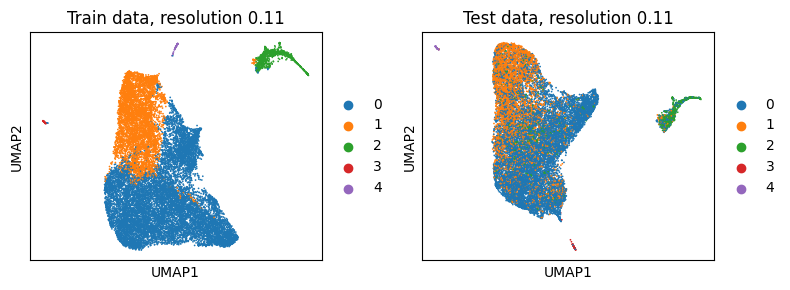

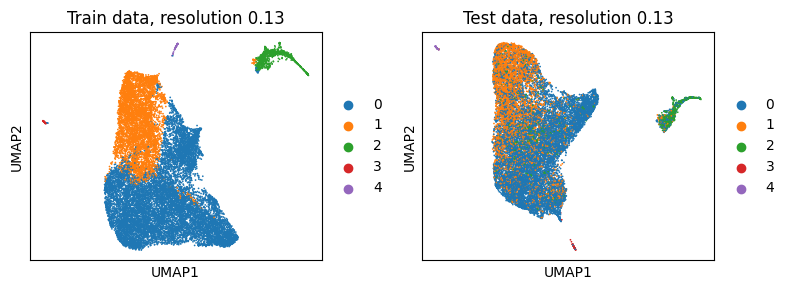

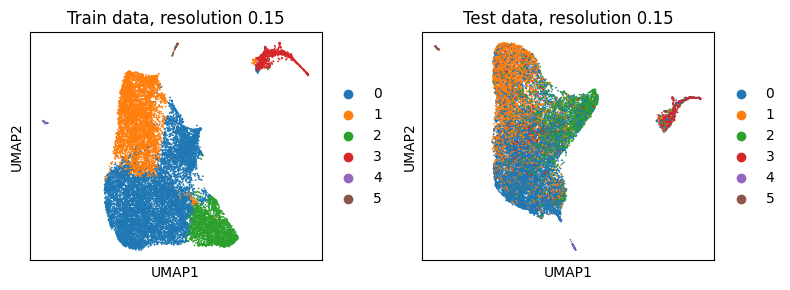

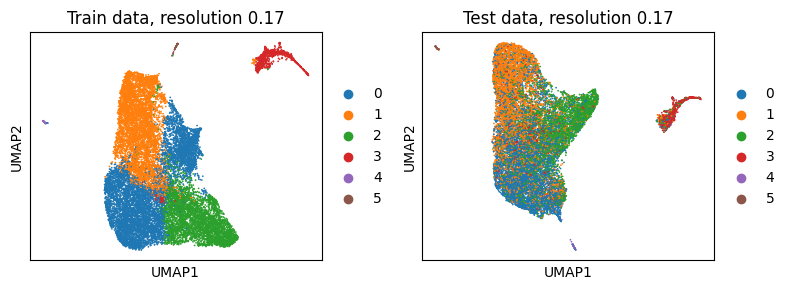

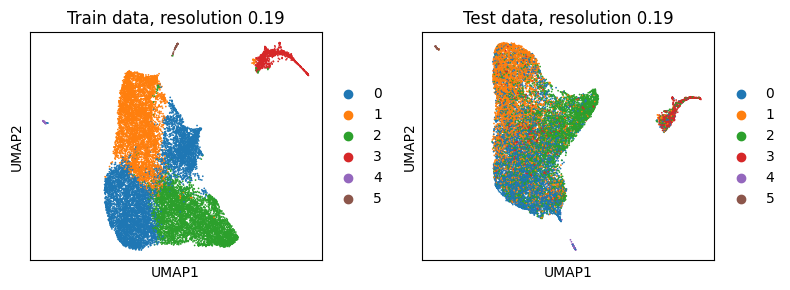

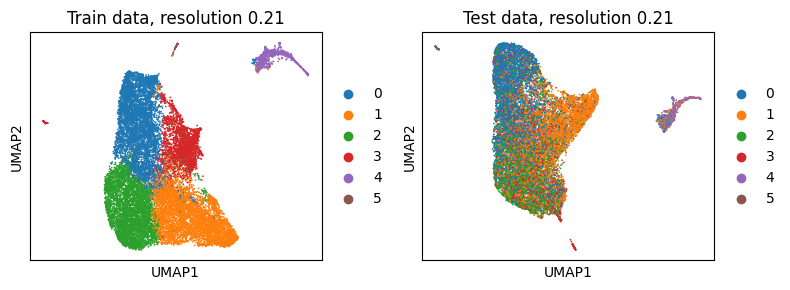

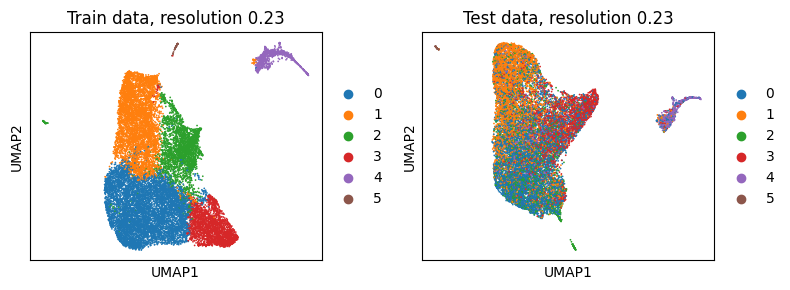

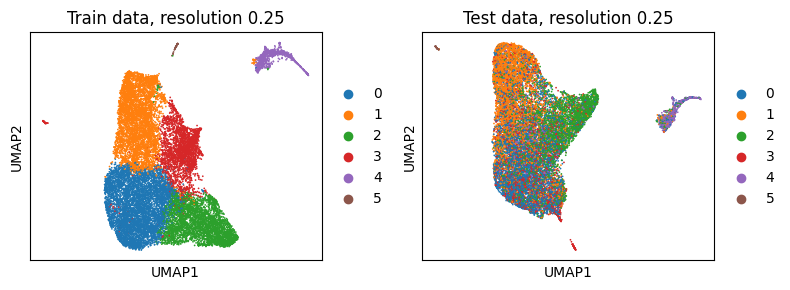

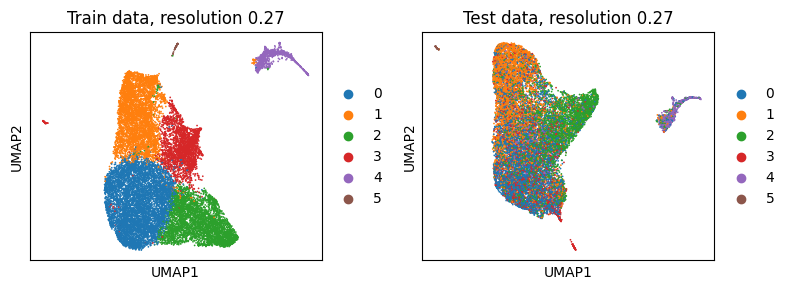

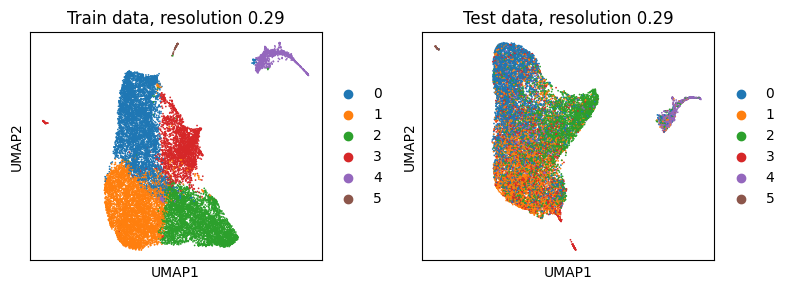

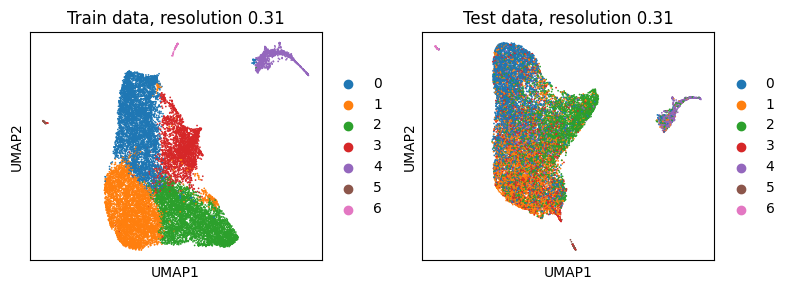

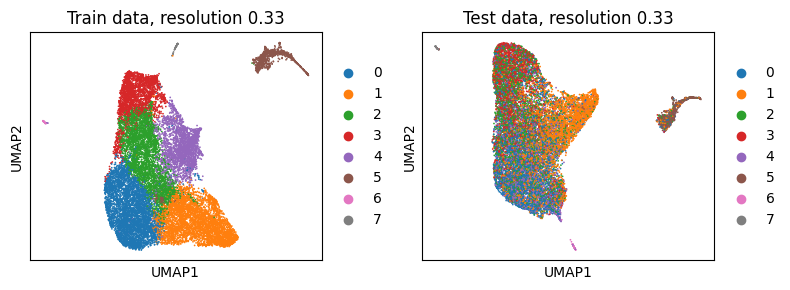

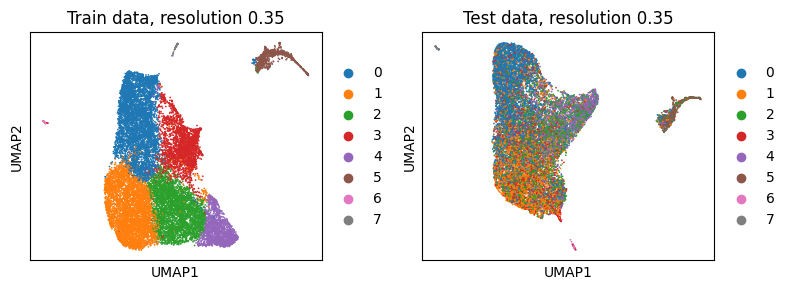

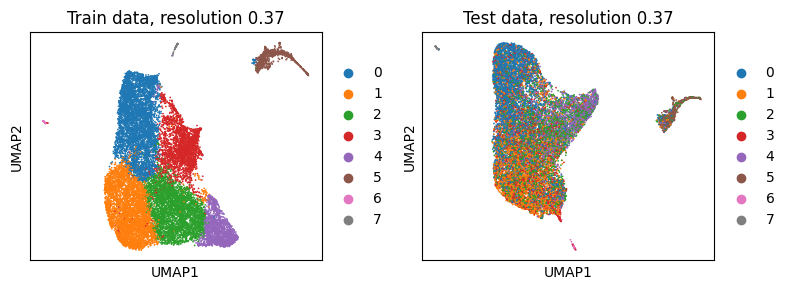

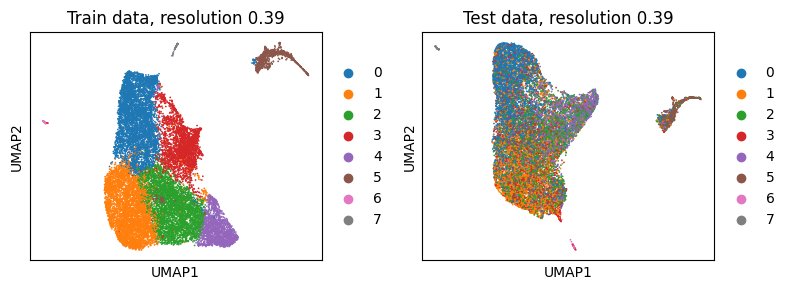

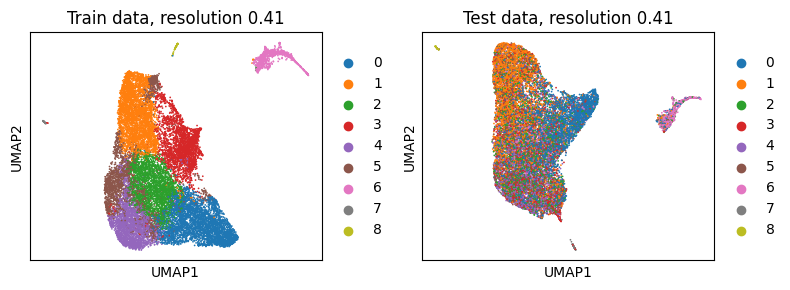

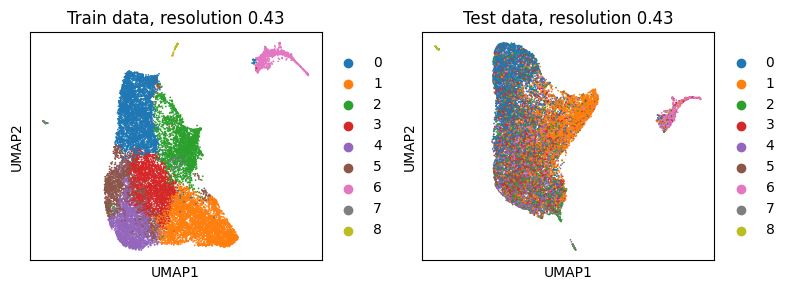

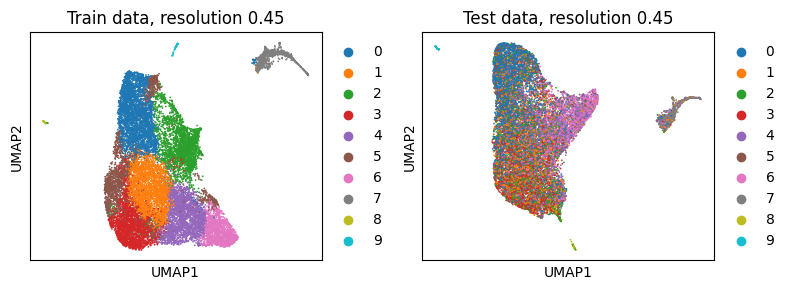

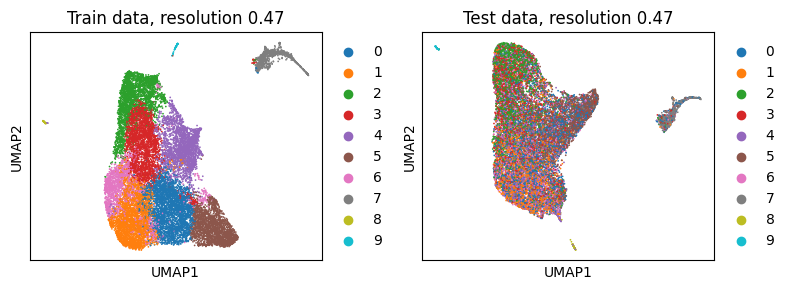

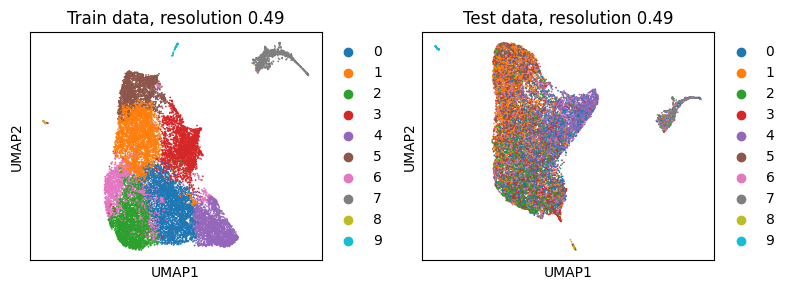

In [40]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [41]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.471 - Test: 0.444 - Random: 0.42
resolution: 0.05 - clusters: 4 - Train: 0.45 - Test: 0.424 - Random: 0.396
resolution: 0.07 - clusters: 4 - Train: 0.433 - Test: 0.406 - Random: 0.379
resolution: 0.09 - clusters: 4 - Train: 0.415 - Test: 0.388 - Random: 0.361
resolution: 0.11 - clusters: 5 - Train: 0.412 - Test: 0.281 - Random: 0.201
resolution: 0.13 - clusters: 5 - Train: 0.401 - Test: 0.27 - Random: 0.189
resolution: 0.15 - clusters: 6 - Train: 0.4 - Test: 0.23 - Random: 0.134
resolution: 0.17 - clusters: 6 - Train: 0.393 - Test: 0.203 - Random: 0.102
resolution: 0.19 - clusters: 6 - Train: 0.388 - Test: 0.189 - Random: 0.093
resolution: 0.21 - clusters: 6 - Train: 0.386 - Test: 0.154 - Random: 0.07
resolution: 0.23 - clusters: 6 - Train: 0.379 - Test: 0.156 - Random: 0.072
resolution: 0.25 - clusters: 6 - Train: 0.376 - Test: 0.149 - Random: 0.06
resolution: 0.27 - clus

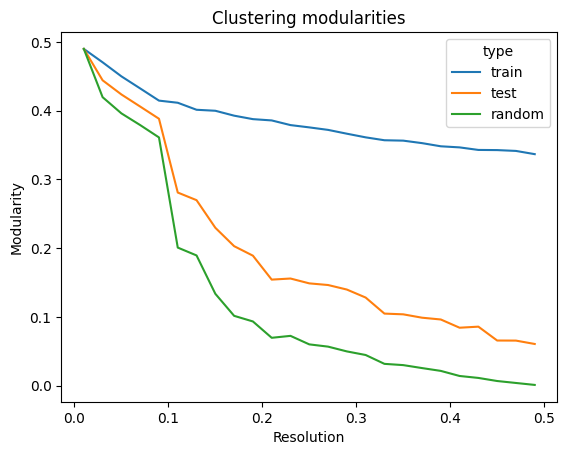

In [42]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

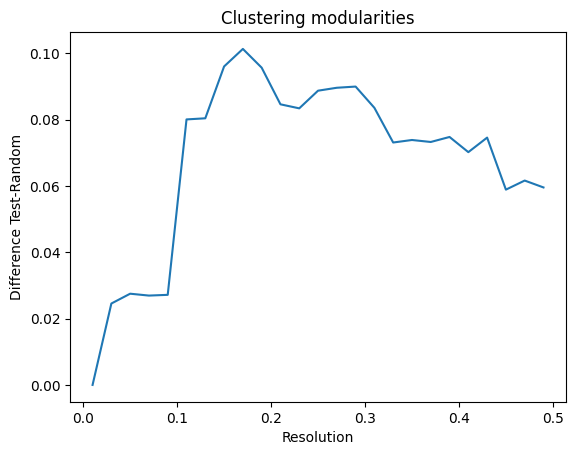

In [43]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [44]:
result_path = "Klebs_antibiotics_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [45]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

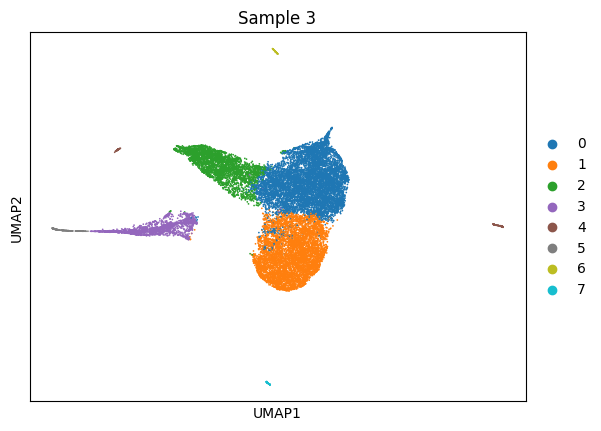

In [46]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [47]:
data_gene.write(data_path + "/antibiotics_data_processed_3.h5ad")

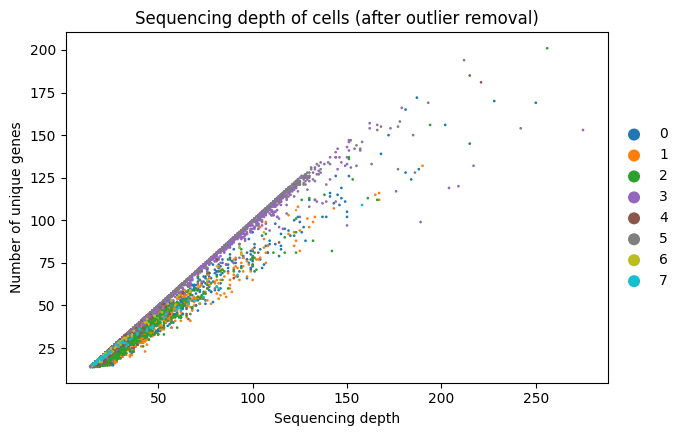

In [48]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

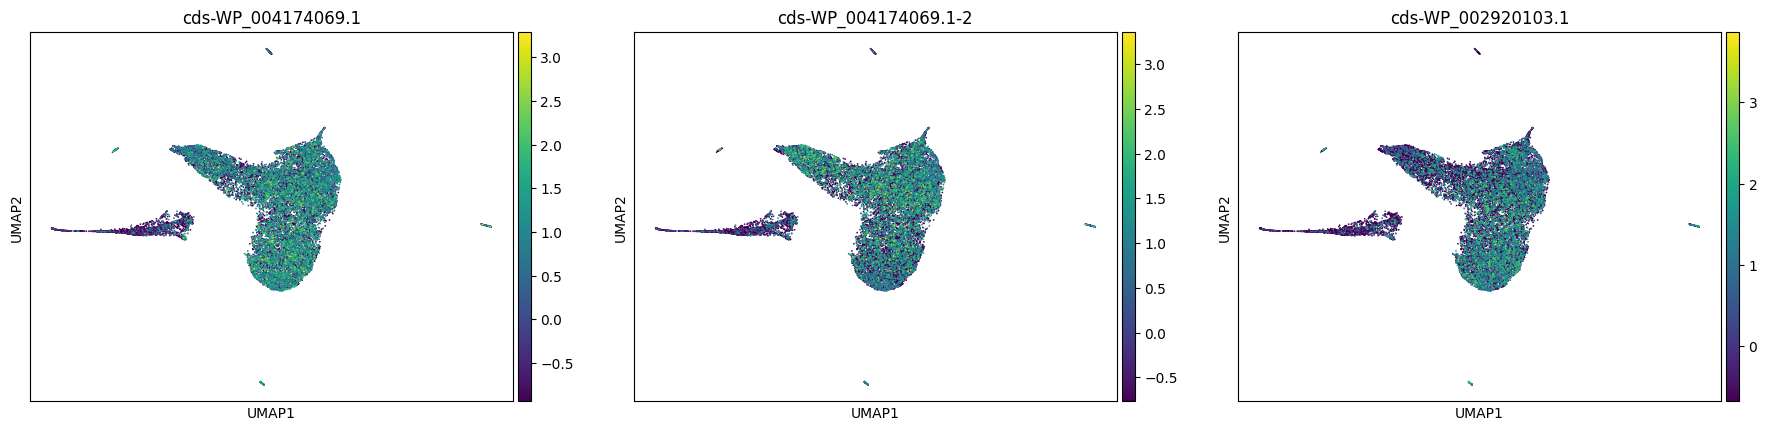

In [49]:
high_expr_genes = ["cds-WP_004174069.1", "cds-WP_004174069.1-2", "cds-WP_002920103.1"]
sc.pl.umap(data_gene, color=high_expr_genes)
plt.show()

## Attach feature table

In [50]:
data_path = "../../data/BacDrop/"
data_gene = sc.read_h5ad(data_path + "/antibiotics_data_processed_3.h5ad")
data_gene

AnnData object with n_obs × n_vars = 19638 × 2500
    obs: 'treatment', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'BacSC_params', 'hvg', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [51]:
feature_table = pd.read_csv(data_path + "genomic_information/klebsiella_MGH66/GCF_000694555.1_Kleb_pneu_MGH_66_V1_feature_table.txt", sep="\t")
feature_table = feature_table[feature_table["# feature"] == "CDS"][["locus_tag", "product_accession", "name", "symbol"]]

feature_table

locus_tag product_accession  \
1       AF52_RS22895    WP_228690219.1   
3       AF52_RS22890               NaN   
5       AF52_RS26590               NaN   
7       AF52_RS26600               NaN   
9     AF52_RS0122900               NaN   
...              ...               ...   
9857    AF52_RS00020    WP_021441167.1   
9859    AF52_RS00015    WP_004214415.1   
9861    AF52_RS00010    WP_002887843.1   
9863    AF52_RS27685    WP_004146984.1   
9865    AF52_RS00005    WP_002887846.1   

                                                   name symbol  
1                              restriction endonuclease    NaN  
3                         IS5/IS1182 family transposase    NaN  
5                         IS5/IS1182 family transposase    NaN  
7                         IS5/IS1182 family transposase    NaN  
9                                           exonuclease    NaN  
...                                                 ...    ...  
9857  two-component system sensor histidine kinase CreC   creC  
9859               cell envelope integrity protein CreD   creD  
9861       two-component system response regulator ArcA   arcA  
9863                               hypothetical protein    NaN  
9865                        tRNA/rRNA methyltransferase    NaN  

[4821 rows x 4 columns]

In [52]:
ind = data_gene.var.index

data_gene.var["lt"] = [x.removeprefix('cds-') for x in data_gene.var.index]
data_gene.var["lt"] = [re.sub(r"-[0-9]+", "", x) for x in data_gene.var["lt"]]
# data_gene.var.drop(columns=["locus_tag", "product_accession", "name", "symbol"], inplace=True)

df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='locus_tag', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df4=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='product_accession', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df5 = pd.merge(df3, df4, how="outer", left_index=True, right_index=True, suffixes=(None, "_y"))

df5.locus_tag.fillna(df5.locus_tag_y, inplace=True)
df5.product_accession.fillna(df5.product_accession_y, inplace=True)
df5.name.fillna(df5.name_y, inplace=True)
df5.symbol.fillna(df5.symbol_y, inplace=True)

df5 = df5.loc[:,~df5.columns.str.endswith('_y')]

mdf = data_gene.var.merge(df5, how="left", left_index=True, right_index=True, suffixes=(None, "_y"))
mdf = mdf.loc[:,~mdf.columns.str.endswith('_y')]
data_gene.var
data_gene.var = mdf

In [ ]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

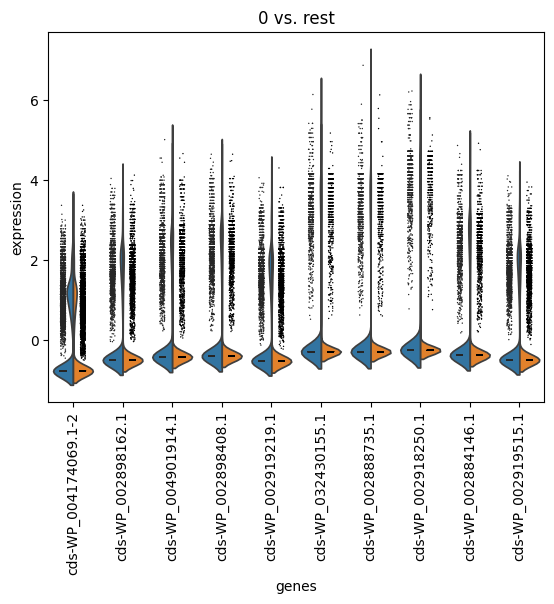

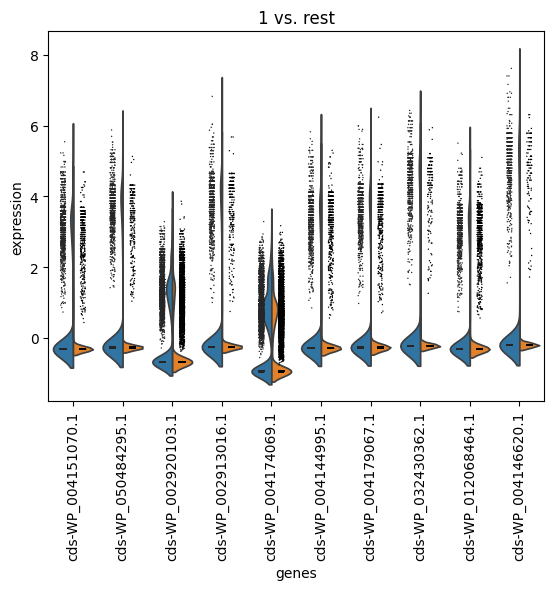

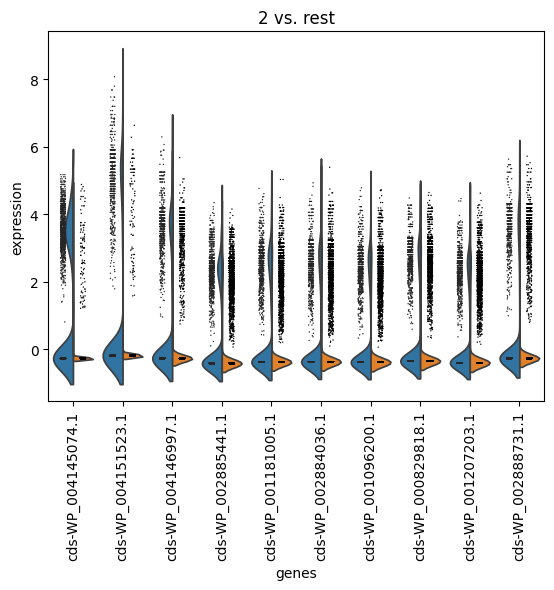

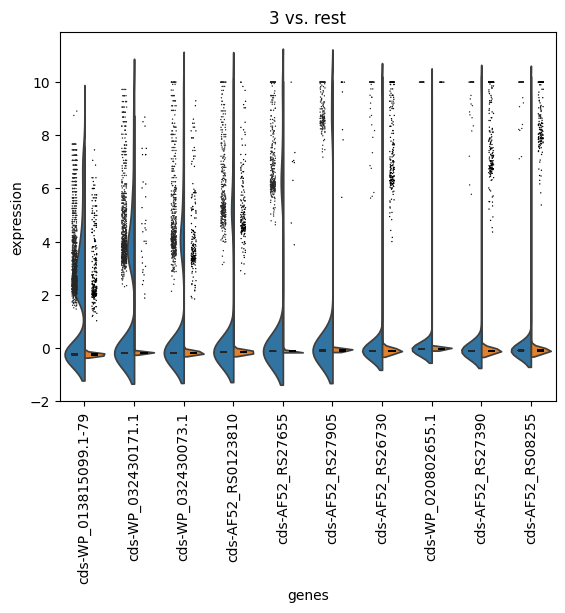

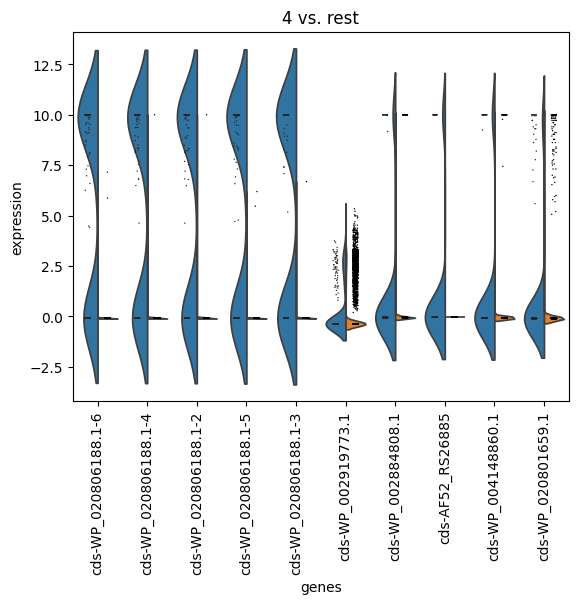

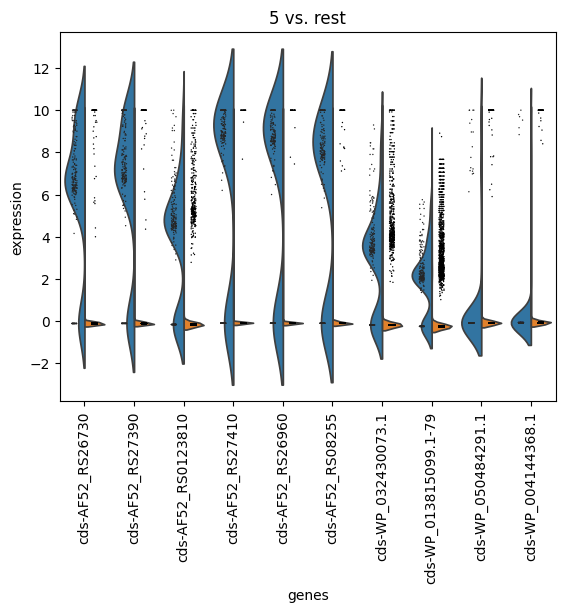

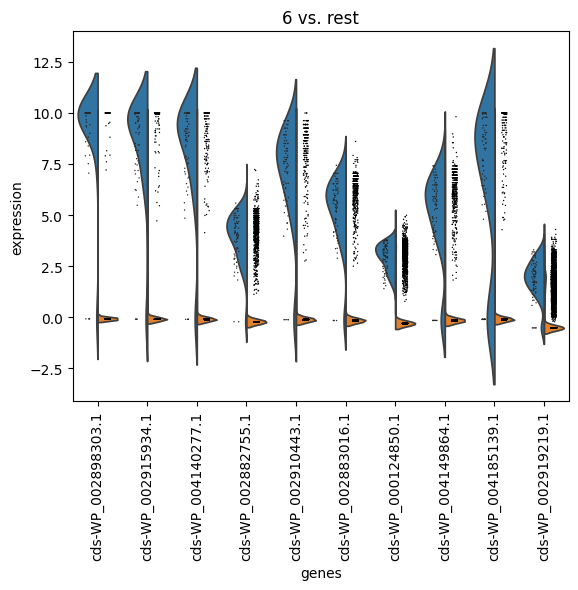

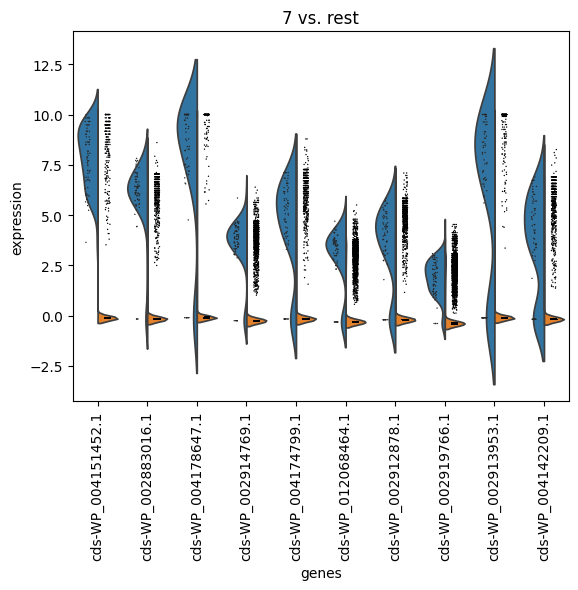

In [54]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

In [55]:
top_genes = [x[1] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(data_gene.var.loc[top_genes[:25], :])


                    n_cells_by_counts  mean_counts  log1p_mean_counts  \
cds-WP_004151070.1               1815     0.110551           0.104856   
cds-WP_050484295.1               1335     0.079132           0.076157   
cds-WP_002920103.1               6663     0.465832           0.382423   
cds-WP_002913016.1               1213     0.068948           0.066675   
cds-WP_004174069.1              10170     0.832519           0.605691   
cds-WP_004144995.1               1535     0.087636           0.084007   
cds-WP_004179067.1               1380     0.078623           0.075685   
cds-WP_032430362.1                936     0.055097           0.053633   
cds-WP_012068464.1               1818     0.108158           0.102699   
cds-WP_004146620.1                778     0.043945           0.043007   
cds-WP_004144748.1               1906     0.108361           0.102883   
cds-WP_002914769.1               1195     0.070017           0.067675   
cds-WP_004144994.1                821     0.045015 

In [56]:
data_gene.write(data_path + "/antibiotics_data_processed_3.h5ad")